# Introduction

So far, our agents have relied on detailed information about how to play the game.  The heuristic really provides a lot of guidance about how to select moves!

In this tutorial, you'll learn how to use **reinforcement learning** to build an intelligent agent without the use of a heuristic.  Instead, we will gradually refine the agent's strategy over time, simply by playing the game and trying to maximize the winning rate.

In this notebook, we won't be able to explore this complex field in detail, but you'll learn about the big picture and explore code that you can use to train your own agent.

# Neural Networks

It's difficult to come up with a perfect heuristic.  Improving the heuristic generally entails playing the game many times, to determine specific cases where the agent could have made better choices.  And, it can prove challenging to interpret what exactly is going wrong, and ultimately to fix old mistakes without accidentally introducing new ones.

Wouldn't it be much easier if we had a more systematic way of improving the agent with gameplay experience?  

In this tutorial, towards this goal, we'll replace the heuristic with a neural network.

The network accepts the current board as input.  And, it outputs a probability for each possible move.

<center>
<img src="https://i.imgur.com/KgAliYQ.png" width=90%><br/>
</center>

Then, the agent selects a move by sampling from these probabilities.  For instance, for the game board in the image above, the agent selects column 4 with 50% probability.

This way, to encode a good gameplay strategy, we need only amend the weights of the network so that _for every possible game board_, it assigns higher probabilities to better moves.

At least in theory, that's our goal.  In practice, we won't actually check if that's the case -- since remember that Connect Four has over 4 trillion possible game boards!

# Setup

How can we approach the task of amending the weights of the network, in practice?  Here's the approach we'll take in this lesson:
- After each move, we give the agent a **reward** that tells it how well it did:
  - **_If_** the agent wins the game in that move, we give it a reward of `+1`.
  - **_Else if_** the agent plays an invalid move (which ends the game), we give it a reward of `-10`.
  - **_Else if_** the opponent wins the game in its next move (i.e., the agent failed to prevent its opponent from winning), we give the agent a reward of `-1`.
  - **_Else_**, the agent gets a reward of `1/42`.
  
  
- At the end of each game, the agent adds up its reward.  We refer to the sum of rewards as the agent's **cumulative reward**.  
  - For instance, if the game lasted 8 moves (each player played four times), and the agent ultimately won, then its cumulative reward is `3*(1/42) + 1`.
  - If the game lasted 11 moves (and the opponent went first, so the agent played five times), and the opponent won in its final move, then the agent's cumulative reward is `4*(1/42) - 1`.
  - If the game ends in a draw, then the agent played exactly 21 moves, and it gets a cumulative reward of `21*(1/42)`.
  - If the game lasted 7 moves and ended with the agent selecting an invalid move, the agent gets a cumulative reward of `3*(1/42) - 10`.
  
Our goal is to find the weights of the neural network that (on average) maximize the agent's cumulative reward.  

This idea of using reward to track the performance of an agent is a core idea in the field of reinforcement learning.  Once we define the problem in this way, we can use any of a variety of reinforcement learning algorithms to produce an agent.

# Reinforcement Learning

There are many different reinforcement learning algorithms, such as DQN, A2C, and PPO, among others.  All of these algorithms use a similar process to produce an agent:

- Initially, the weights are set to random values.


- As the agent plays the game, the algorithm continually tries out new values for the weights, to see how the cumulative reward is affected, on average.  Over time, after playing many games, we get a good idea of how the weights affect cumulative reward, and the algorithm settles towards weights that performed better.  
    - _Of course, we have glossed over the details here, and there's a lot of complexity involved in this process.  For now, we focus on the big picture!_
    
    
- This way, we'll end up with an agent that tries to win the game (so it gets the final reward of `+1`, and avoids the `-1` and `-10`) and tries to make the game last as long as possible (so that it collects the `1/42` bonus as many times as it can).
    - _You might argue that it doesn't really make sense to want the game to last as long as possible -- this might result in a very inefficient agent that doesn't play obvious winning moves early in gameplay.  And, your intuition would be correct -- this will make the agent take longer to play a winning move!  The reason we include the `1/42` bonus is to help the algorithms we'll use to converge better.  Further discussion is outside of the scope of this course, but you can learn more by reading about the "temporal credit assignment problem" and "reward shaping"._
    
In the next section, we'll use the [**Proximal Policy Optimization (PPO)**](https://openai.com/blog/openai-baselines-ppo/) algorithm to create an agent.

# Code

There are a lot of great implementations of reinforcement learning algorithms online.  In this course, we'll use [Stable Baselines](https://github.com/hill-a/stable-baselines).

Currently, Stable Baselines is not yet compatible with TensorFlow 2.0.  So, we begin by downgrading to TensorFlow 1.0.

In [1]:
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Check version of tensorflow
!pip install 'tensorflow==1.15.0'
import tensorflow as tf
#tf.__version__

There's a bit of extra work that we need to do to make the environment compatible with Stable Baselines.  For this, we define the `ConnectFourGym` class below.  This class implements ConnectX as an [OpenAI Gym environment](http://gym.openai.com/docs/) and uses several methods:
- `reset()` will be called at the beginning of every game.  It returns the starting game board as a 2D numpy array with 6 rows and 7 columns.
- `change_reward()` customizes the rewards that the agent receives.  (_The competition already has its own system for rewards that are used to rank the agents, and this method changes the values to match the rewards system we designed._) 
- `step()` is used to play the agent's choice of action (supplied as `action`), along with the opponent's response.  It returns:
  - the resulting game board (as a numpy array), 
  - the agent's reward (from the most recent move only: one of `+1`, `-10`, `-1`, or `1/42`), and
  - whether or not the game has ended (if the game has ended, `done=True`; otherwise, `done=False`).
  
To learn more about how to define environments, check out the documentation [here](https://stable-baselines.readthedocs.io/en/master/guide/custom_env.html).

In [ ]:
!pip install kaggle_environments

In [5]:
from kaggle_environments import make, evaluate
from gym import spaces

class ConnectFourGym:
    def __init__(self, agent2="random"):
        ks_env = make("connectx", debug=True)
        self.env = ks_env.train([None, agent2])
        self.rows = ks_env.configuration.rows
        self.columns = ks_env.configuration.columns
        # Learn about spaces here: http://gym.openai.com/docs/#spaces
        self.action_space = spaces.Discrete(self.columns)
        self.observation_space = spaces.Box(low=0, high=2, 
                                            shape=(self.rows,self.columns,1), dtype=np.int)
        # Tuple corresponding to the min and max possible rewards
        self.reward_range = (-10, 1)
        # StableBaselines throws error if these are not defined
        self.spec = None
        self.metadata = None
    def reset(self):
        self.obs = self.env.reset()
        return np.array(self.obs['board']).reshape(self.rows,self.columns,1)
    def change_reward(self, old_reward, done):
        if old_reward == 1: # The agent won the game
            return 1
        elif done: # The opponent won the game
            return -1
        else: # Reward 1/42
            return 1/(self.rows*self.columns)
    def step(self, action):
        # Check if agent's move is valid
        is_valid = (self.obs['board'][int(action)] == 0)
        if is_valid: # Play the move
            self.obs, old_reward, done, _ = self.env.step(int(action))
            reward = self.change_reward(old_reward, done)
        else: # End the game and penalize agent
            reward, done, _ = -10, True, {}
        return np.array(self.obs['board']).reshape(self.rows,self.columns,1), reward, done, _

Loading environment football failed: No module named 'gfootball'


In this notebook, we'll train an agent to beat the random agent.  We specify this opponent in the `agent2` argument below.

In [6]:
# Create ConnectFour environment
env = ConnectFourGym(agent2="random")

Stable Baselines requires us to work with ["vectorized" environments](https://stable-baselines.readthedocs.io/en/master/guide/vec_envs.html).  For this, we can use the `DummyVecEnv` class.  

The `Monitor` class lets us watch how the agent's performance gradually improves, as it plays more and more games.

In [ ]:
!apt-get update
!apt-get install -y cmake libopenmpi-dev python3-dev zlib1g-dev
!pip install "stable-baselines[mpi]==2.9.0"

In [8]:
import os
from stable_baselines.bench import Monitor 
from stable_baselines.common.vec_env import DummyVecEnv

# Create directory for logging training information
log_dir = "ppo/"
os.makedirs(log_dir, exist_ok=True)

# Logging progress
monitor_env = Monitor(env, log_dir, allow_early_resets=True)

# Create a vectorized environment
vec_env = DummyVecEnv([lambda: monitor_env])

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The next step is to specify the architecture of the neural network.  In this case, we use a convolutional neural network.  To learn more about how to specify architectures with Stable Baselines, check out the documentation [here](https://stable-baselines.readthedocs.io/en/master/guide/custom_policy.html).

Note that this is the neural network that outputs the probabilities of selecting each column.  Since we use the PPO algorithm (`PPO1` in the code cell below), our network will also output some additional information (called the "value" of the input).  This is outside the scope of this course, but you can learn more by reading about "actor-critic networks".

In [9]:
from stable_baselines import PPO1 
from stable_baselines.a2c.utils import conv, linear, conv_to_fc
from stable_baselines.common.policies import CnnPolicy

# Neural network for predicting action values
def modified_cnn(scaled_images, **kwargs):
    activ = tf.nn.relu
    layer_1 = activ(conv(scaled_images, 'c1', n_filters=32, filter_size=3, stride=1, 
                         init_scale=np.sqrt(2), **kwargs))
    layer_2 = activ(conv(layer_1, 'c2', n_filters=64, filter_size=3, stride=1, 
                         init_scale=np.sqrt(2), **kwargs))
    layer_2 = conv_to_fc(layer_2)
    return activ(linear(layer_2, 'fc1', n_hidden=512, init_scale=np.sqrt(2)))  

class CustomCnnPolicy(CnnPolicy):
    def __init__(self, *args, **kwargs):
        super(CustomCnnPolicy, self).__init__(*args, **kwargs, cnn_extractor=modified_cnn)
        
# Initialize agent
model = PPO1(CustomCnnPolicy, vec_env, verbose=0)















Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In the code cell above, the weights of the neural network are initially set to random values.

In the next code cell, we "train the agent", which is just another way of saying that we find weights of the neural network that are likely to result in the agent selecting good moves.

We plot a rolling average of the cumulative reward that the agent received during training.  As evidenced by the increasing function, the agent gradually learned to perform better by playing the game.

In [10]:
# Train agent
start = time.time()
nsteps = 10000
model.learn(total_timesteps=nsteps)
print (nsteps,"steps took",time.time()-start,"seconds.")

10000 steps took 47.43256950378418 seconds.


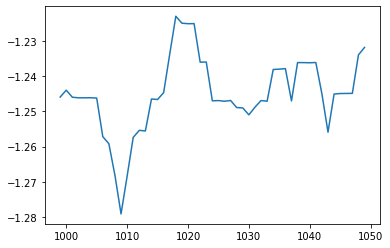

In [11]:
#%%time
# Plot cumulative reward
with open(os.path.join(log_dir, "monitor.csv"), 'rt') as fh:    
    firstline = fh.readline()
    assert firstline[0] == '#'
    df = pd.read_csv(fh, index_col=None)['r']
df.rolling(window=1000).mean().plot()
plt.show()

Finally, we specify the trained agent in the format required for the competition.

In [12]:
model.save('./ppo')

In [13]:
new_model = PPO1.load('/content/ppo.zip')

In [15]:
new_model


In [ ]:
def learner(obs, config):
    # Use the best model to select a column
    col, _ = model.predict(np.array(obs['board']).reshape(6,7,1))
    # Check if selected column is valid
    is_valid = (obs['board'][int(col)] == 0)
    # If not valid, select random move. 
    if is_valid:
        return int(col)
    else:
        return random.choice([col for col in range(config.columns) if obs.board[int(col)] == 0])

In the next code cell, we see the outcome of one game round against a random agent.

In [ ]:
# Create the game environment
env = make("connectx")

# Two random agents play one game round
env.run([learner, "random"])
#env.play([None, "random"])

# Show the game
env.render(mode="ipython")

And, we calculate how it performs on average, against the random agent.

In [ ]:
def get_win_percentages(agent1, agent2, n_rounds=1):
    # Use default Connect Four setup
    config = {'rows': 6, 'columns': 7, 'inarow': 4}
    # Agent 1 goes first (roughly) half the time          
    outcomes = evaluate("connectx", [agent1, agent2], config, [], n_rounds//2)
    # Agent 2 goes first (roughly) half the time      
    outcomes += [[b,a] for [a,b] in evaluate("connectx", [agent2, agent1], config, [], n_rounds-n_rounds//2)]
    print("Agent 1 Win Percentage:", np.round(outcomes.count([1,-1])/len(outcomes), 2))
    print("Agent 2 Win Percentage:", np.round(outcomes.count([-1,1])/len(outcomes), 2))
    print("Number of Invalid Plays by Agent 1:", outcomes.count([None, 0]))
    print("Number of Invalid Plays by Agent 2:", outcomes.count([0, None]))

In [ ]:
start_time = time.time()
n_rounds=1000
#get_win_percentages(agent1=my_agent, agent2=my_agent, n_rounds=n_rounds)
get_win_percentages(agent1=learner, agent2="random",n_rounds=n_rounds)
print ("Total time taken: {} seconds".format(time.time() - start_time))
print ("Time taken per round: {} seconds".format((time.time() - start_time)/n_rounds))

It's important to note that the agent that we've created here was only trained to beat the random agent, because all of its gameplay experience has been with the random agent as opponent.  

If we want to produce an agent that reliably performs better than many other agents, we have to expose our agent to these other agents during training.  To learn more about how to do this, you can read about **[self-play](https://openai.com/blog/competitive-self-play/)**.

# Learn more

This was a very quick and high-level introduction to reinforcement learning.  If you'd like to dig more deeply into this topic, we recommend checking out the following (free!) resources:
- David Silver's videos - [here](https://www.youtube.com/watch?v=2pWv7GOvuf0)
- Richard Sutton's and Andrew Barto's textbook - [here](http://www.incompleteideas.net/book/RLbook2018.pdf)
- Denny Britz's GitHub repository - [here](https://github.com/dennybritz/reinforcement-learning)
- The Deep RL Bootcamp - [here](https://sites.google.com/corp/view/deep-rl-bootcamp/lectures)

# Your turn

Continue to check your understanding and **[run the code yourself](https://www.kaggle.com/kernels/fork/8222487)**!

---




*Have questions or comments? Visit the [Learn Discussion forum](https://www.kaggle.com/learn-forum/161477) to chat with other Learners.*